In [3]:
import re

offsets = {}
with open("log/inject.log", "r") as file:
    content = file.readlines()
    print(content)
    pattern_bait = re.compile(r"bait_before,bait_after: (\d+),(\d+)")
    pattern_some = re.compile(r'Some\("([^"]+)"\)')
    pattern_none = re.compile(r"None")
    pattern_pathname = re.compile(r'pathname: Some\("([^"]+)"\)')
    for line in content:
        match = pattern_bait.search(line)
        if match:
            key = (int(match.group(1)), int(match.group(2)))
            offsets[key] = []
        pathname_match = pattern_pathname.search(line)
        some_match = pattern_some.search(line)
        none_match = pattern_none.search(line)
        if pathname_match:
            pathname = pathname_match.group(1)
            offsets[key].append(pathname)
        elif some_match:
            offsets[key].append(some_match.group(1))
        elif none_match:
            offsets[key].append("Not reused")
        match = pattern_some.search(line)
offsets

['bait_before,bait_after: 0,0\n', 'None\n', 'None\n', 'None\n', 'None\n', 'None\n', 'None\n', 'None\n', 'None\n', 'None\n', 'None\n', 'bait_before,bait_after: 0,1\n', 'Some(FlippyPage { maps_entry: MapsEntry { region: MemoryRegion { start: 102785010229248, end: 102785010233344 }, perms: READ, offset: 8192, dev: DeviceNumbers { major: 8, minor: 2 }, inode: 11575986, pathname: Some("/home/jb/rowhammer-jb/victim-stack/stack") }, region_offset: 0 })\n', 'Some(FlippyPage { maps_entry: MapsEntry { region: MemoryRegion { start: 109751532687360, end: 109751532691456 }, perms: READ, offset: 8192, dev: DeviceNumbers { major: 8, minor: 2 }, inode: 11575986, pathname: Some("/home/jb/rowhammer-jb/victim-stack/stack") }, region_offset: 0 })\n', 'Some(FlippyPage { maps_entry: MapsEntry { region: MemoryRegion { start: 111349642113024, end: 111349642117120 }, perms: READ, offset: 8192, dev: DeviceNumbers { major: 8, minor: 2 }, inode: 11575986, pathname: Some("/home/jb/rowhammer-jb/victim-stack/stack")

{(0, 0): ['Not reused',
  'Not reused',
  'Not reused',
  'Not reused',
  'Not reused',
  'Not reused',
  'Not reused',
  'Not reused',
  'Not reused',
  'Not reused'],
 (0, 1): ['/home/jb/rowhammer-jb/victim-stack/stack',
  '/home/jb/rowhammer-jb/victim-stack/stack',
  '/home/jb/rowhammer-jb/victim-stack/stack',
  '/home/jb/rowhammer-jb/victim-stack/stack',
  'Not reused',
  '/home/jb/rowhammer-jb/victim-stack/stack',
  '/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2',
  '/home/jb/rowhammer-jb/victim-stack/stack',
  'Not reused',
  '/home/jb/rowhammer-jb/victim-stack/stack'],
 (0, 2): ['Not reused',
  'Not reused',
  '[heap]',
  '[heap]',
  '[heap]',
  '[heap]',
  'Not reused',
  '[heap]',
  '[heap]',
  'Not reused'],
 (0, 3): ['/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2',
  '/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2',
  '/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2',
  '/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2',
  '/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2',
  '

In [4]:
data = offsets

from collections import Counter
max_key = max(data, key=lambda k: Counter(data[k])['[stack]'])

print(max_key)

(9, 5)


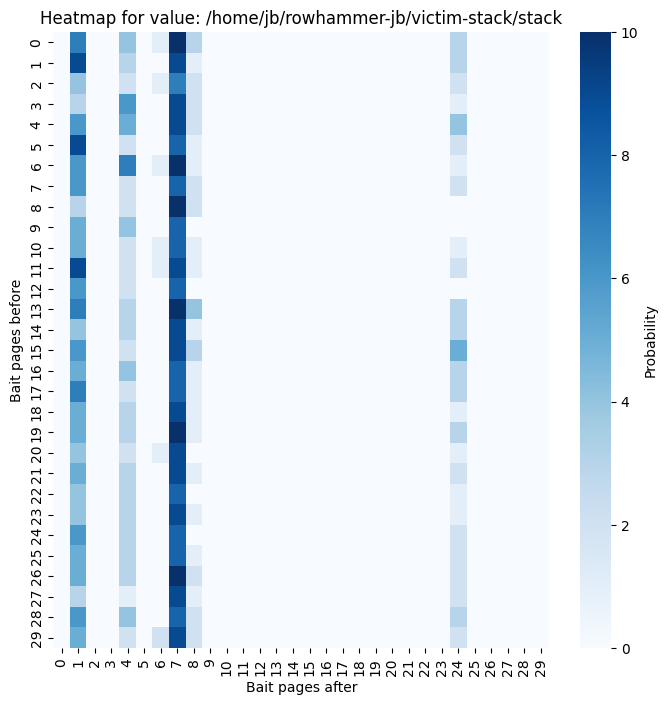

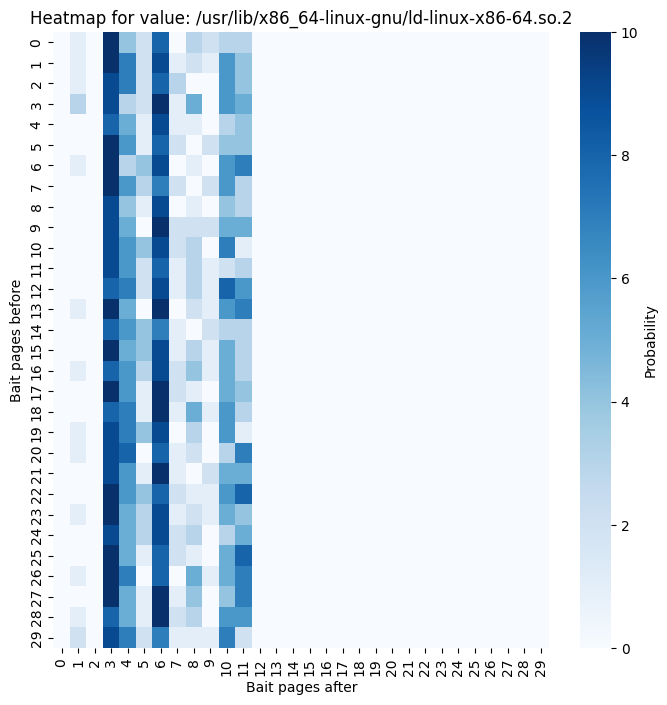

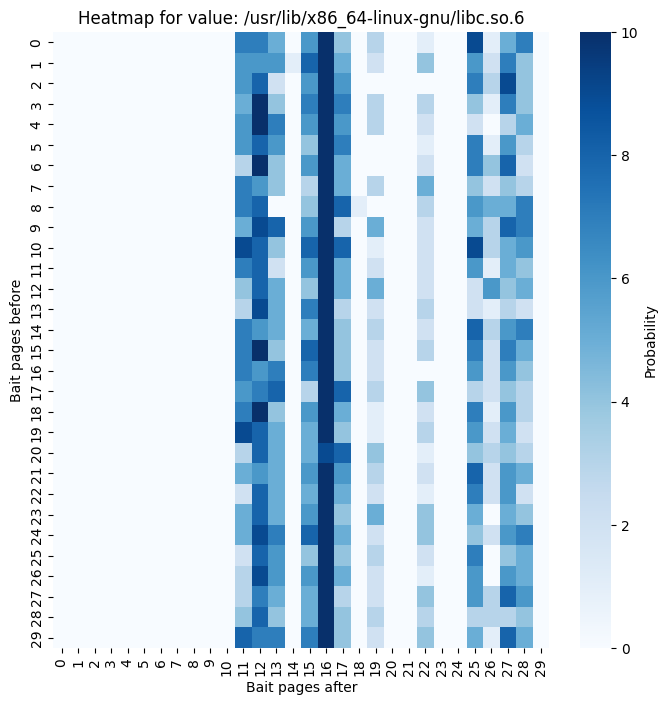

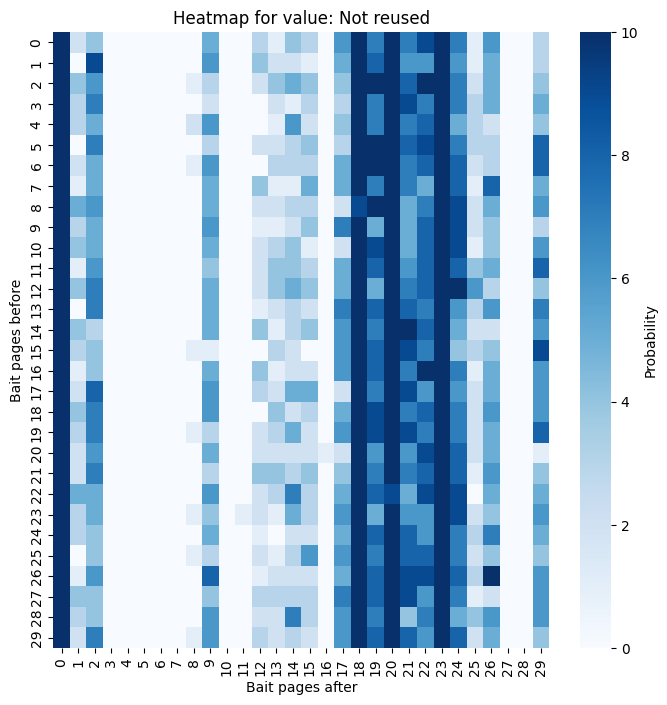

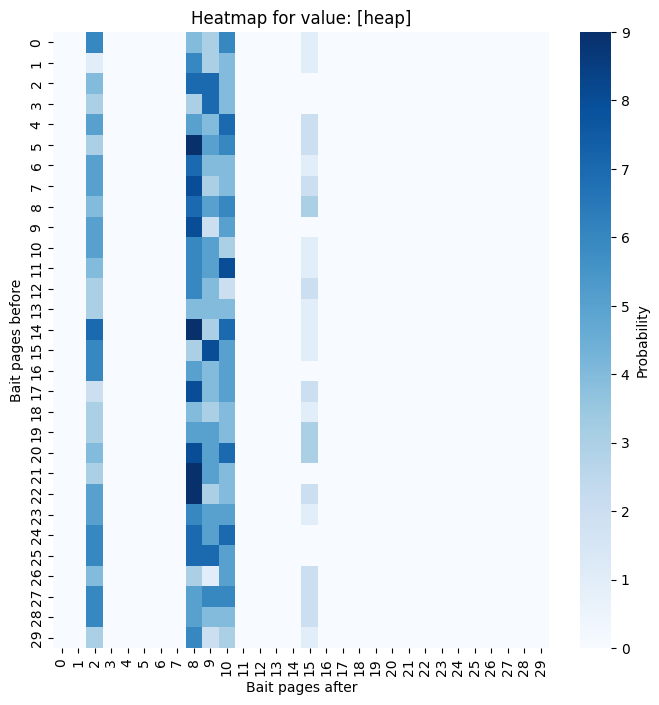

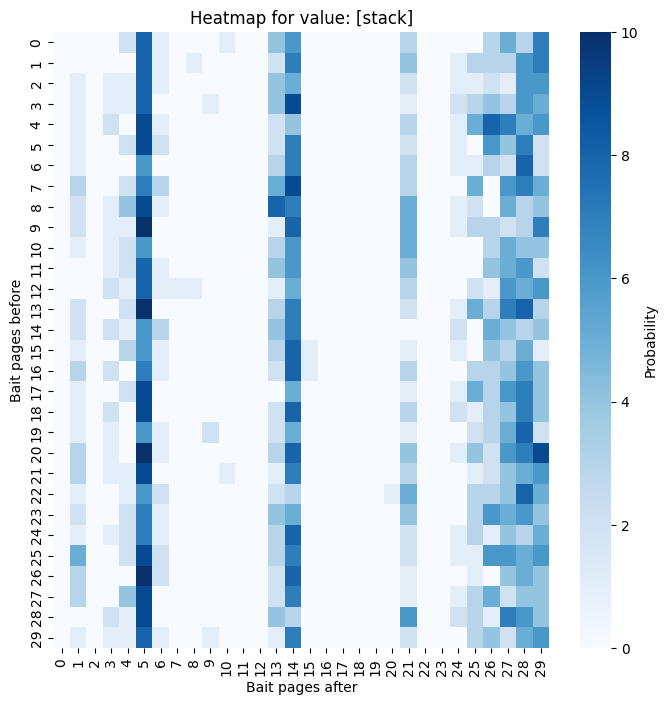

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
data = offsets

# Convert data into a suitable format
# Create a set of unique values
keys = data.keys()
dim_x = max(key[0] for key in keys) + 1
dim_y = max(key[1] for key in keys) + 1
unique_values = sorted(set(value for values in data.values() for value in values))

# Create an empty matrix for heatmap
heatmap_data = np.zeros((30, 30, len(unique_values)))

# Populate the heatmap data
for (x, y), values in data.items():
    if x >= 30 or y >= 30:
        continue
    for value in values:
        idx = unique_values.index(value)
        heatmap_data[x, y, idx] += 1

# Plot heatmaps for each unique value
for i, value in enumerate(unique_values):
    plt.figure(figsize=(8, 8))
    sns.heatmap(heatmap_data[:, :, i], cmap='Blues', 
                xticklabels='auto', yticklabels='auto', 
                cbar_kws={'label': 'Probability'})
    plt.title(f'Heatmap for value: {value}')
    plt.xlabel('Bait pages after')
    plt.ylabel('Bait pages before')
    plt.show()

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample data (use the full data in your case)
data = offsets

# Get all unique values across all keys and convert to a sorted list
unique_values = sorted(set(value for values in data.values() for value in values))

if False:
    # Plot for each key
    for key, values in data.items():
        values = data[key]
        # Count occurrences of each unique value for the current key
        value_counts = Counter(values)
        
        if value_counts.get('None') == len(values):
            continue

        # Extract counts in the same order as unique_values
        counts = [value_counts.get(value, 0) for value in unique_values]
        values = [v for v in unique_values if counts[unique_values.index(v)] != 0]
        counts = [c for c in counts if c != 0]
        
        # Plotting
        plt.figure(figsize=(8, 4))
        plt.bar(values, counts, color='skyblue')
        
        # Labels and title
        plt.xlabel("Memory Region")
        plt.ylabel("Count")
        plt.title(f"Page injected into memory region for {key} (before/after) bait pages")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig(f"plots/plot_{key}.png")
        plt.close()
